# Sensitivity Analysis Notebook Past Surgery

## Introduction

In this notebook, we perform a sensitivity analysis to compare ambiguity attitudes in the medical domain in people with a history of surgery.


## Libraries Used

First, we import the necessary libraries for data manipulation, probabilistic programming, and visualization.


In [1]:
# Data manipulation and analysis
import pandas as pd  # For data manipulation and analysis
import numpy as np  # For numerical operations and array manipulation

# Probabilistic programming and Bayesian statistical modeling
import pymc as pm  
import arviz as az  

# Data visualization
import matplotlib.pyplot as plt 
import seaborn as sns  

# Suppressing warnings for cleaner output
import warnings
warnings.filterwarnings('ignore')

import logging
logger = logging.getLogger("pymc")
logger.propagate = False
logger.setLevel(logging.ERROR)

## Load data for in person sample

In [2]:
db_mon = pd.read_csv('data/mon_clean.csv')
db_med = pd.read_csv('data/med_clean.csv')

print('N Participants: ', len(db_mon['sub'].unique()))

N Participants:  66


## Load Surgery history file

In [3]:
surgery = pd.read_csv('data/surgery.csv')

db_mon = db_mon.merge(surgery, left_on='sub', right_on='sub')
db_med = db_med.merge(surgery, left_on='sub', right_on='sub')

## Create data sets for analsis 

In [4]:
def ns(db):
    db['subn'] = db['sub'].rank(method='dense').astype(int) - 1
    n_subs = db['subn'].unique().shape[0]
    sub_idx = db.subn.tolist()
    return(n_subs, sub_idx)


In [5]:
# Split the dataframe based on surgery
db_mon_yes = db_mon[db_mon['surgery'] == 'yes']
db_mon_no = db_mon[db_mon['surgery'] == 'no']

db_med_yes = db_med[db_med['surgery'] == 'yes']
db_med_no = db_med[db_med['surgery'] == 'no']

n_subs_yes, sub_idx_yes = ns(db_mon_yes)
n_subs_no,  sub_idx_no  = ns(db_mon_no)

n_subs_yes_med, sub_idx_yes_med = ns(db_med_yes)
n_subs_no_med,  sub_idx_no_med  = ns(db_med_no)

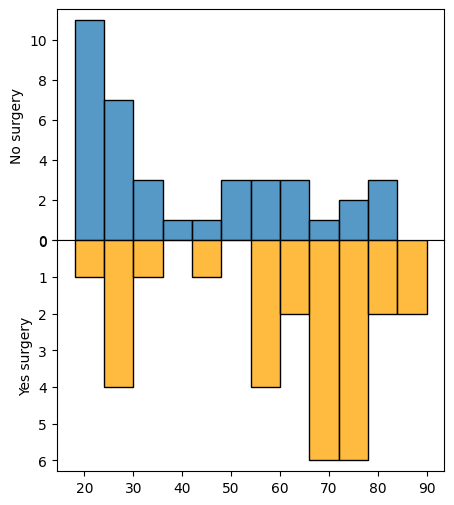

In [6]:
no  = list(db_mon_no.drop_duplicates('sub')['age'])
yes = list(db_mon_yes.drop_duplicates('sub')['age'])

# Create a subplot layout with 2 rows and 1 column.
fig, ax = plt.subplots(2, 1, figsize=(5, 6), sharex=True)

# On the first subplot (top), plot the age distribution for female participants
sns.histplot(no, binwidth=6, ax=ax[0])

# On the second subplot (bottom), plot the age distribution for male participants using an orange color
sns.histplot(yes, binwidth=6, color='orange', ax=ax[1])

# Set the y-labels for both subplots to denote the gender, and only set an x-label for the bottom plot
ax[0].set(ylabel='No surgery', xlabel='')
ax[1].set(ylabel='Yes surgery')

# Invert the y-axis for the male age distribution to have the histogram bars grow upwards 
# (this makes it visually comparable with the female age distribution)
ax[1].invert_yaxis()

# Adjust the space between subplots to make them touch (removing any gap)
plt.subplots_adjust(wspace=0, hspace=0)

## Model estimated values

In [7]:
def estimate_value(df, n_subs, idx):
    """
    Estimate the value of different reward levels using ordinal constraints and a common hyperprior for each level. 
    The model ensures that the levels are positive (ordinal constraints).

    Parameters:
    - df: DataFrame with trial-specific details, such as choices, value levels, risk, and ambiguity levels.
    - n_sub: Total number of subjects in the dataset.
    - idx: A list indicating the subject ID for each observation/trial.

    Returns:
    - trace: Samples from the posterior distribution of the model.
    """
    
    with pm.Model() as estimate:

        # Hyperparameters for group-level distributions
        bMu  = pm.Normal('bMu', .65, 1)     # Mean for ambiguity effect distribution
        bSig = pm.Gamma('bSig', 2, 1)       # SD for ambiguity effect distribution


       # Hyperparameters for group-level subjective value levels
        l1Mu = pm.TruncatedNormal('l1Mu', 4, 2, lower=0)  # Mean for value of level 1
        l2Mu = pm.TruncatedNormal('l2Mu', 4, 2, lower=0)  # ... level 2
        l3Mu = pm.TruncatedNormal('l3Mu', 4, 2, lower=0)  # ... level 3
        l4Mu = pm.TruncatedNormal('l4Mu', 4, 2, lower=0)  # ... level 4
        
        l1sd = pm.Gamma('l1sd', 3, 1)  # SD for value of level 1
        l2sd = pm.Gamma('l2sd', 3, 1)  # ... level 2
        l3sd = pm.Gamma('l3sd', 3, 1)  # ... level 3
        l4sd = pm.Gamma('l4sd', 3, 1)  # ... level 4
        
        # Subject-specific priors 
        β = pm.Normal('β',    bMu, bSig, shape = n_subs)   # Modulation of ambiguity effect
        γ = pm.Lognormal('γ', 0, 0.25, shape = n_subs)   # Inverse temperature, impacting choice stochasticity

        # Priors for subjective values of the different reward levels for each subject.
        level1 = pm.TruncatedNormal('level1', l1Mu, l1sd, lower = 0, shape = n_subs)
        level2 = pm.TruncatedNormal('level2', l2Mu, l2sd, lower = 0, shape = n_subs)
        level3 = pm.TruncatedNormal('level3', l3Mu, l3sd, lower = 0, shape = n_subs)
        level4 = pm.TruncatedNormal('level4', l4Mu, l4sd, lower = 0, shape = n_subs)

        # Calculate the total expected value for each trial by combining values from different levels
        val = (df['l1'].values * level1[idx] + 
               df['l2'].values * level2[idx] + 
               df['l3'].values * level3[idx] + 
               df['l4'].values * level4[idx]) 

        # Calculate adjusted probability by considering both risk and ambiguity levels modulated by β
        prob = (df['risk'].values) - (β[idx] * (df['ambiguity'].values/2))  

        # Compute the subjective value of the lottery option
        svLotto = val * prob
        svRef   = level1[idx]  # The subjective value of the reference option

        # Transform the SV difference between lottery and reference into a choice probability using the logistic function
        p  = (svLotto - svRef) / γ[idx]
        mu = pm.invlogit(p)

        # Likelihood of the observed choices given the computed probabilities
        choice = pm.Binomial('choice', 1, mu, observed=df['choice'])

        trace = pm.sample(idata_kwargs={'log_likelihood':True})
        
    return(trace)

In [8]:
mon_estimated     = estimate_value(db_mon_yes, n_subs_yes, sub_idx_yes)
med_estimated = estimate_value(db_med_yes, n_subs_yes_med, sub_idx_yes_med)
mon_estimated_no     = estimate_value(db_mon_no, n_subs_no, sub_idx_no)
med_estimated_no = estimate_value(db_med_no, n_subs_no_med, sub_idx_no_med)


In [9]:
print("Estimated values People with No History:")

print("level 1 (med): mean:", round(az.summary(med_estimated_no, var_names=['level1'])['mean'].mean(),2), "SD: ", round(az.summary(med_estimated_no, var_names=['level1'])['sd'].mean(),2))
print("level 2 (med): mean:", round(az.summary(med_estimated_no, var_names=['level2'])['mean'].mean(),2), "SD: ", round(az.summary(med_estimated_no, var_names=['level2'])['sd'].mean(),2))
print("level 3 (med): mean:", round(az.summary(med_estimated_no, var_names=['level3'])['mean'].mean(),2), "SD: ", round(az.summary(med_estimated_no, var_names=['level3'])['sd'].mean(),2))
print("level 4 (med): mean:", round(az.summary(med_estimated_no, var_names=['level4'])['mean'].mean(),2), "SD: ", round(az.summary(med_estimated_no, var_names=['level4'])['sd'].mean(),2))
print()
print("level 1 (mon): mean:", round(az.summary(mon_estimated_no, var_names=['level1'])['mean'].mean(),2), "SD: ", round(az.summary(mon_estimated_no, var_names=['level1'])['sd'].mean(),2))
print("level 2 (mon): mean:", round(az.summary(mon_estimated_no, var_names=['level2'])['mean'].mean(),2), "SD: ", round(az.summary(mon_estimated_no, var_names=['level2'])['sd'].mean(),2))
print("level 3 (mon): mean:", round(az.summary(mon_estimated_no, var_names=['level3'])['mean'].mean(),2), "SD: ", round(az.summary(mon_estimated_no, var_names=['level3'])['sd'].mean(),2))
print("level 4 (mon): mean:", round(az.summary(mon_estimated_no, var_names=['level4'])['mean'].mean(),2), "SD: ", round(az.summary(mon_estimated_no, var_names=['level4'])['sd'].mean(),2))

Estimated values People with No History:
level 1 (med): mean: 7.35 SD:  1.8
level 2 (med): mean: 8.75 SD:  2.5
level 3 (med): mean: 8.18 SD:  3.06
level 4 (med): mean: 3.58 SD:  2.16

level 1 (mon): mean: 6.98 SD:  1.43
level 2 (mon): mean: 3.01 SD:  1.17
level 3 (mon): mean: 6.94 SD:  2.24
level 4 (mon): mean: 9.9 SD:  3.72


In [10]:
print("Estimated values People with a History:")

print("level 1 (med): mean:", round(az.summary(med_estimated, var_names=['level1'])['mean'].mean(),2), "SD: ", round(az.summary(med_estimated, var_names=['level1'])['sd'].mean(),2))
print("level 2 (med): mean:", round(az.summary(med_estimated, var_names=['level2'])['mean'].mean(),2), "SD: ", round(az.summary(med_estimated, var_names=['level2'])['sd'].mean(),2))
print("level 3 (med): mean:", round(az.summary(med_estimated, var_names=['level3'])['mean'].mean(),2), "SD: ", round(az.summary(med_estimated, var_names=['level3'])['sd'].mean(),2))
print("level 4 (med): mean:", round(az.summary(med_estimated, var_names=['level4'])['mean'].mean(),2), "SD: ", round(az.summary(med_estimated, var_names=['level4'])['sd'].mean(),2))
print()
print("level 1 (mon): mean:", round(az.summary(mon_estimated, var_names=['level1'])['mean'].mean(),2), "SD: ", round(az.summary(mon_estimated, var_names=['level1'])['sd'].mean(),2))
print("level 2 (mon): mean:", round(az.summary(mon_estimated, var_names=['level2'])['mean'].mean(),2), "SD: ", round(az.summary(mon_estimated, var_names=['level2'])['sd'].mean(),2))
print("level 3 (mon): mean:", round(az.summary(mon_estimated, var_names=['level3'])['mean'].mean(),2), "SD: ", round(az.summary(mon_estimated, var_names=['level3'])['sd'].mean(),2))
print("level 4 (mon): mean:", round(az.summary(mon_estimated, var_names=['level4'])['mean'].mean(),2), "SD: ", round(az.summary(mon_estimated, var_names=['level4'])['sd'].mean(),2))

Estimated values People with a History:
level 1 (med): mean: 5.96 SD:  1.66
level 2 (med): mean: 8.61 SD:  2.62
level 3 (med): mean: 5.65 SD:  2.53
level 4 (med): mean: 5.03 SD:  2.71

level 1 (mon): mean: 7.19 SD:  1.77
level 2 (mon): mean: 5.44 SD:  1.83
level 3 (mon): mean: 5.14 SD:  1.95
level 4 (mon): mean: 6.85 SD:  2.81


## Plot Values

In [11]:
# Similar process for the monetery dataset
df = db_mon_yes[['sub','age', 'gender']].sort_values('sub').drop_duplicates().reset_index(drop=True)
df['age'] = df.age.astype('int')

# extract parameters from the model
level1 = az.summary(mon_estimated, var_names=['level1'])[['mean']]
level2 = az.summary(mon_estimated, var_names=['level2'])[['mean']]
level3 = az.summary(mon_estimated, var_names=['level3'])[['mean']]
level4 = az.summary(mon_estimated, var_names=['level4'])[['mean']]
beta   = az.summary(mon_estimated, var_names=['β']     )[['mean']]

# change column names
level1 = level1.rename(columns={'mean': "level1_mon"}).reset_index(drop=True)
level2 = level2.rename(columns={'mean': "level2_mon"}).reset_index(drop=True)
level3 = level3.rename(columns={'mean': "level3_mon"}).reset_index(drop=True)
level4 = level4.rename(columns={'mean': "level4_mon"}).reset_index(drop=True)
beta   = beta.rename(  columns={'mean': "amb_est_mon"}  ).reset_index(drop=True)

# combine to a single dataframe
df = df.merge(level1, left_index=True, right_index=True)
df = df.merge(level2, left_index=True, right_index=True)
df = df.merge(level3, left_index=True, right_index=True)
df = df.merge(level4, left_index=True, right_index=True)
df = df.merge(beta,   left_index=True, right_index=True)


In [12]:
# extract parameters from the model
level1 = az.summary(med_estimated, var_names=['level1'])[['mean']]
level2 = az.summary(med_estimated, var_names=['level2'])[['mean']]
level3 = az.summary(med_estimated, var_names=['level3'])[['mean']]
level4 = az.summary(med_estimated, var_names=['level4'])[['mean']]
beta   = az.summary(med_estimated, var_names=['β']     )[['mean']]

# change column names
level1 = level1.rename(columns={'mean': "level1_med"}).reset_index(drop=True)
level2 = level2.rename(columns={'mean': "level2_med"}).reset_index(drop=True)
level3 = level3.rename(columns={'mean': "level3_med"}).reset_index(drop=True)
level4 = level4.rename(columns={'mean': "level4_med"}).reset_index(drop=True)
beta   = beta.rename(  columns={'mean': "amb_est_med"}  ).reset_index(drop=True)

# combine to a single dataframe
df = df.merge(level1, left_index=True, right_index=True)
df = df.merge(level2, left_index=True, right_index=True)
df = df.merge(level3, left_index=True, right_index=True)
df = df.merge(level4, left_index=True, right_index=True)
df = df.merge(beta,   left_index=True, right_index=True)

In [13]:
# Similar process for the monetery dataset
df_no = db_mon_no[['sub','age', 'gender']].sort_values('sub').drop_duplicates().reset_index(drop=True)
df_no['age'] = df.age.astype('int')

# extract parameters from the model
level1 = az.summary(mon_estimated_no, var_names=['level1'])[['mean']]
level2 = az.summary(mon_estimated_no, var_names=['level2'])[['mean']]
level3 = az.summary(mon_estimated_no, var_names=['level3'])[['mean']]
level4 = az.summary(mon_estimated_no, var_names=['level4'])[['mean']]
beta   = az.summary(mon_estimated_no, var_names=['β']     )[['mean']]

# change column names
level1 = level1.rename(columns={'mean': "level1_mon"}).reset_index(drop=True)
level2 = level2.rename(columns={'mean': "level2_mon"}).reset_index(drop=True)
level3 = level3.rename(columns={'mean': "level3_mon"}).reset_index(drop=True)
level4 = level4.rename(columns={'mean': "level4_mon"}).reset_index(drop=True)
beta   = beta.rename(  columns={'mean': "amb_est_mon"}  ).reset_index(drop=True)

# combine to a single dataframe
df_no = df_no.merge(level1, left_index=True, right_index=True)
df_no = df_no.merge(level2, left_index=True, right_index=True)
df_no = df_no.merge(level3, left_index=True, right_index=True)
df_no = df_no.merge(level4, left_index=True, right_index=True)
df_no = df_no.merge(beta,   left_index=True, right_index=True)

In [14]:
# extract parameters from the model
level1 = az.summary(med_estimated_no, var_names=['level1'])[['mean']]
level2 = az.summary(med_estimated_no, var_names=['level2'])[['mean']]
level3 = az.summary(med_estimated_no, var_names=['level3'])[['mean']]
level4 = az.summary(med_estimated_no, var_names=['level4'])[['mean']]
beta   = az.summary(med_estimated_no, var_names=['β']     )[['mean']]

# change column names
level1 = level1.rename(columns={'mean': "level1_med"}).reset_index(drop=True)
level2 = level2.rename(columns={'mean': "level2_med"}).reset_index(drop=True)
level3 = level3.rename(columns={'mean': "level3_med"}).reset_index(drop=True)
level4 = level4.rename(columns={'mean': "level4_med"}).reset_index(drop=True)
beta   = beta.rename(  columns={'mean': "amb_est_med"}  ).reset_index(drop=True)

# combine to a single dataframe
df_no = df_no.merge(level1, left_index=True, right_index=True)
df_no = df_no.merge(level2, left_index=True, right_index=True)
df_no = df_no.merge(level3, left_index=True, right_index=True)
df_no = df_no.merge(level4, left_index=True, right_index=True)
df_no = df_no.merge(beta,   left_index=True, right_index=True)


In [15]:
def corr(x, y):
    with pm.Model() as RR:

        a = pm.Normal('intercept', 0, 1)
        b = pm.Normal('slope', 0, 1)
        eps = pm.Exponential('eps', 1)
        y_hat = a + b*x

        nu = pm.InverseGamma("nu", alpha=3, beta=1)

        likelihood = pm.StudentT("likelihood", mu=y_hat, sigma=eps, nu=nu, observed=y)

        trace_robust = pm.sample()
        
    return(trace_robust)

In [16]:
est   = corr(df.amb_est_mon, df.amb_est_med)
est_no = corr(df_no.amb_est_mon, df_no.amb_est_med)


es   = az.summary(est, var_names=['slope','intercept'], hdi_prob=.89)[['mean','hdi_5.5%','hdi_94.5%']]
es_no = az.summary(est_no, var_names=['slope','intercept'], hdi_prob=.89)[['mean','hdi_5.5%','hdi_94.5%']]


In [17]:
# calculate the SV of each level
df['level1m'] = df['level1_mon']
df['level2m'] = df['level1m'] + df['level2_mon']
df['level3m'] = df['level2m'] + df['level3_mon']
df['level4m'] = df['level3m'] + df['level4_mon']

# Reshape the data frame from wide to long format using the melt function.
df_long_mon = df.melt(id_vars='sub',
                      value_vars=['level1m', 'level2m', 'level3m', 'level4m'], 
                      var_name='level')


level_mapping = {
    'level1m': 5,
    'level2m': 8,
    'level3m': 12,
    'level4m': 25
}


# Apply the mapping to the 'level' column in 'df_long_med' and create a new column 'levelName' that holds the descriptive names.
df_long_mon['levelName'] = df_long_mon['level'].map(level_mapping)

df['level1md'] = df['level1_med']
df['level2md'] = df['level1md'] + df['level2_med']
df['level3md'] = df['level2md'] + df['level3_med']
df['level4md'] = df['level3md'] + df['level4_med']

# Reshape the dataframe 'df' from wide to long format using the melt function.
df_long_med = df.melt(id_vars='sub',
                      value_vars=['level1md', 'level2md', 'level3md', 'level4md'], 
                      var_name='level')


# Create a mapping dictionary for levels. This provides a more descriptive name for each 'level' in 'df_long_med'.
level_mapping = {
    'level1md': 'Slight',
    'level2md': 'Moderate',
    'level3md': 'Major',
    'level4md': 'Complete recovery'
}

# Apply the mapping to the 'level' column in 'df_long_med' and create a new column 'levelName' that holds the descriptive names.
df_long_med['levelName'] = df_long_med['level'].map(level_mapping)

In [18]:
# calculate the SV of each level
df_no['level1m'] = df_no['level1_mon']
df_no['level2m'] = df_no['level1m'] + df_no['level2_mon']
df_no['level3m'] = df_no['level2m'] + df_no['level3_mon']
df_no['level4m'] = df_no['level3m'] + df_no['level4_mon']

df_long_mon_no = df_no.melt(id_vars='sub',
                            value_vars=['level1m', 'level2m', 'level3m', 'level4m'],
                            var_name='level')


level_mapping = {
    'level1m': 5,
    'level2m': 8,
    'level3m': 12,
    'level4m': 25
}


# Apply the mapping to the 'level' column in 'df_long_med' and create a new column 'levelName' that holds the descriptive names.
df_long_mon_no['levelName'] = df_long_mon_no['level'].map(level_mapping)

df_no['level1md'] = df_no['level1_med']
df_no['level2md'] = df_no['level1md'] + df_no['level2_med']
df_no['level3md'] = df_no['level2md'] + df_no['level3_med']
df_no['level4md'] = df_no['level3md'] + df_no['level4_med']

# Reshape the dataframe 'df' from wide to long format using the melt function.
df_long_med_no = df.melt(id_vars='sub',
                         value_vars=['level1md', 'level2md', 'level3md', 'level4md'],
                         var_name='level')


# Create a mapping dictionary for levels. This provides a more descriptive name for each 'level' in 'df_long_med'.
level_mapping = {
    'level1md': 'Slight',
    'level2md': 'Moderate',
    'level3md': 'Major',
    'level4md': 'Complete recovery'
}

# Apply the mapping to the 'level' column in 'df_long_med' and create a new column 'levelName' that holds the descriptive names.
df_long_med_no['levelName'] = df_long_med_no['level'].map(level_mapping)

In [19]:
df_long_med['subn']  = df_long_med['sub'].rank(method='dense').astype(int) - 1
df_long_mon['subn']  = df_long_mon['sub'].rank(method='dense').astype(int) - 1

df_long_med_no['subn']  = df_long_med_no['sub'].rank(method='dense').astype(int) - 1
df_long_mon_no['subn']  = df_long_mon_no['sub'].rank(method='dense').astype(int) - 1

df_long_mon['levelName'] = df_long_mon['levelName'].astype('str')
df_long_mon_no['levelName'] = df_long_mon_no['levelName'].astype('str')

In [20]:
import matplotlib
from mpl_toolkits.axes_grid1 import make_axes_locatable

In [21]:
norm = matplotlib.colors.Normalize(vmin=0, vmax=65)
colors = {}
cmap = plt.get_cmap('tab20', 66)  # Create a colormap with 66 unique colors

for cval in range(0,66):
    colors.update({cval : cmap(norm(cval))})

norm2 = matplotlib.colors.Normalize(vmin=0, vmax=332)
colors2 = {}
cmap2 = plt.get_cmap('tab20', 332)  

for cval2 in range(0,332):
    colors2.update({cval2 : cmap2(norm2(cval2))})

In [22]:
# Function to add the mean as a big black dot
def add_mean_dot(ax, data, x, y):
    means = data.groupby(x)[y].mean().reset_index()
    ax.scatter(means[x], means[y], s=200, color='black', zorder=3)

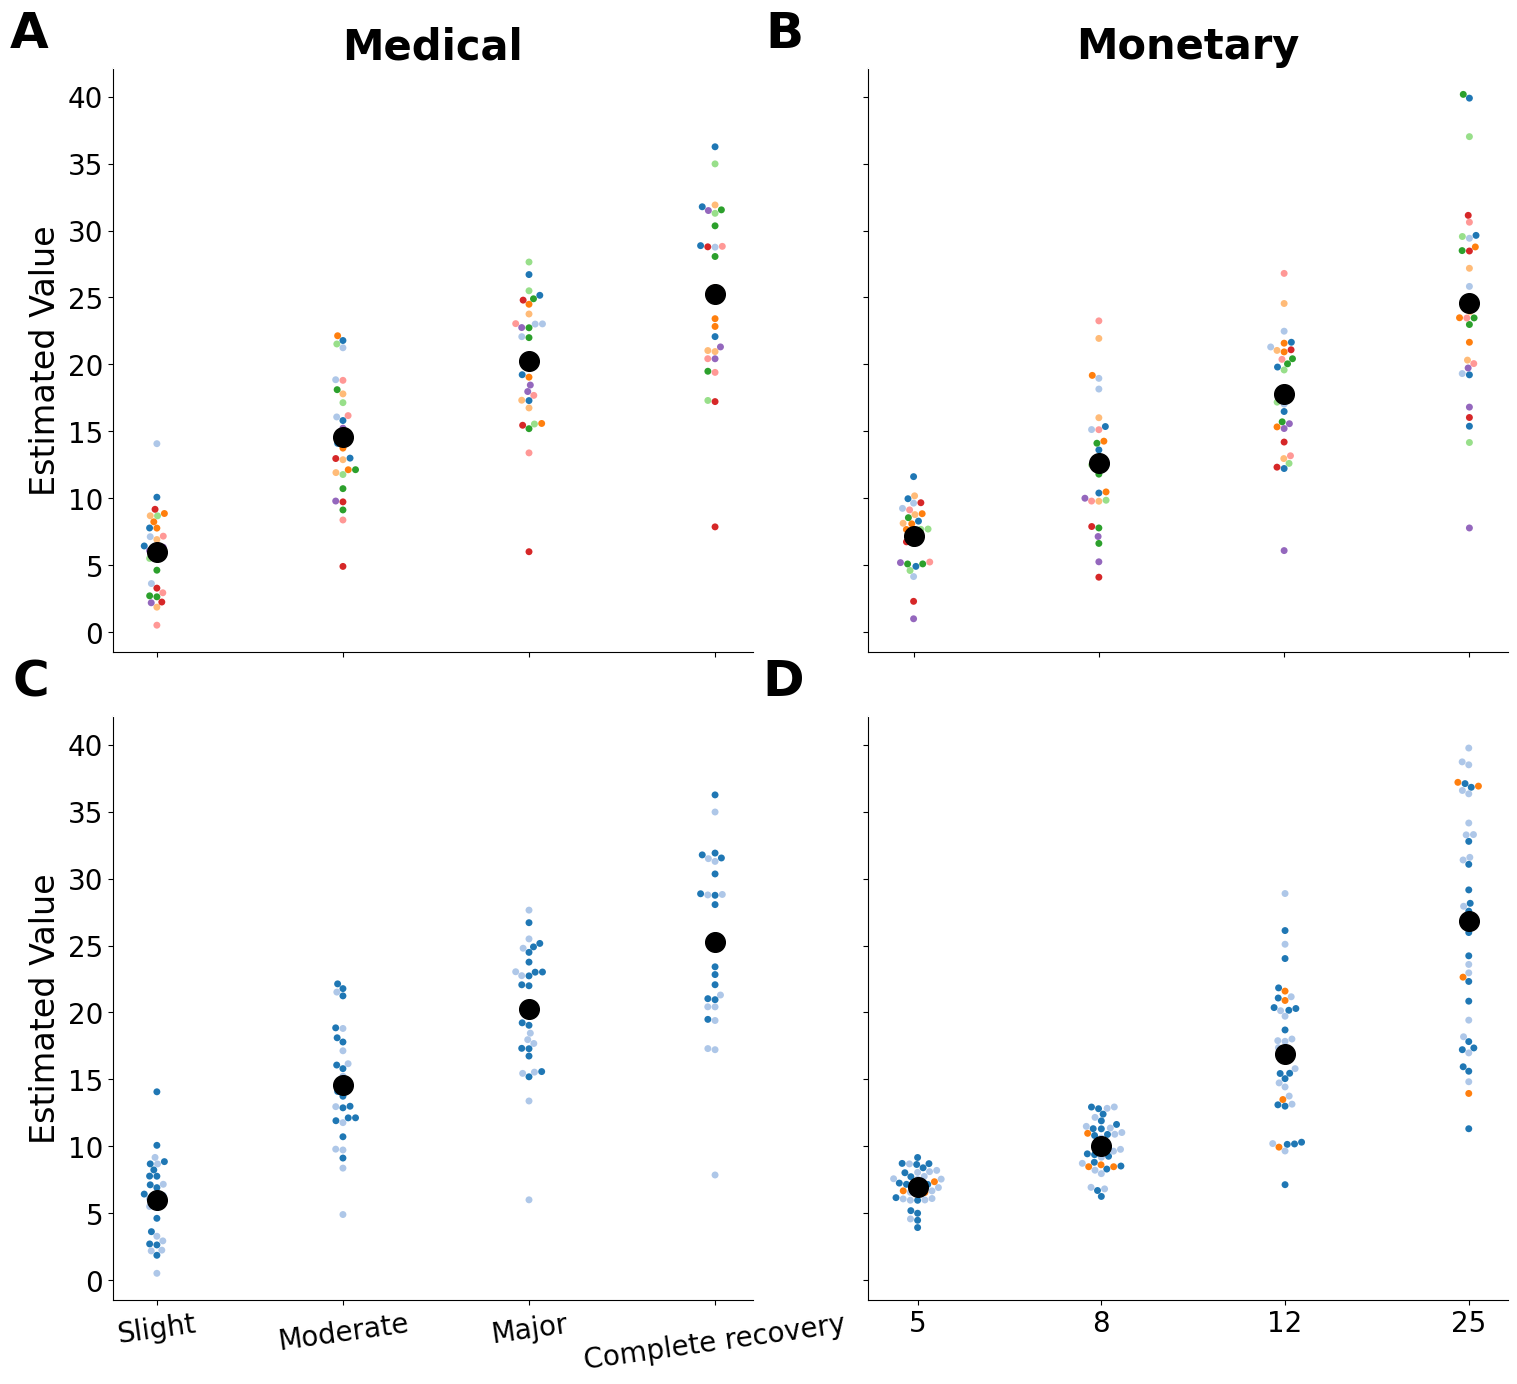

In [23]:
# This will visualize the relationship between different levels and their estimated values for Monetary and Medical contexts.
fig, axes = plt.subplots(2, 2, figsize=(18, 16), sharey=True) # Initialize a 1x2 subplot layout, with a shared y-axis.


# Plot the estimated value for each level in the 'Medical' context on the second axis.
sns.swarmplot(data=df_long_med, x='levelName', y='value', ax=axes[0,0], hue = 'subn', palette = colors)
sns.swarmplot(data=df_long_med_no, x='levelName', y='value', ax=axes[1,0], hue = 'subn', palette = colors2)

# Plot the estimated value for each level in the 'Monetary' context on the first axis.
sns.swarmplot(data=df_long_mon, x='levelName', y='value', ax=axes[0,1], hue = 'subn', palette = colors)
sns.swarmplot(data=df_long_mon_no, x='levelName', y='value', ax=axes[1,1], hue = 'subn', palette = colors2)


# Set the title for each subplot.
axes[0,0].set_title('Medical', fontweight="bold", size=30)
axes[0,1].set_title('Monetary', fontweight="bold", size=30)

# Set the y-axis label for the first subplot.
axes[0,0].set_ylabel('Estimated Value', fontsize=24.0)
axes[0,1].set_ylabel('', fontsize=24.0)
axes[1,0].set_ylabel('Estimated Value', fontsize=24.0)
axes[1,1].set_ylabel('', fontsize=24.0)

axes[0, 0].set_xticklabels([])
axes[0, 1].set_xticklabels([])

# Add a slight rotation to the x-axis tick labels on the second plot for better visualization.
axes[1,0].tick_params(axis='x', labelrotation=8)

# Add the mean dots to each subplot
add_mean_dot(axes[0, 0], df_long_med, 'levelName', 'value')
add_mean_dot(axes[1, 0], df_long_med_no, 'levelName', 'value')
add_mean_dot(axes[0, 1], df_long_mon, 'levelName', 'value')
add_mean_dot(axes[1, 1], df_long_mon_no, 'levelName', 'value')

# Set the background color for both plots to white for clarity and aesthetic appeal.
for i in range(2):
    for j in range(2):
        axes[i,j].tick_params(axis='both', which='major', labelsize=20)
        axes[i][j].legend_.remove()
        axes[i,j].set_facecolor('White')
        axes[i,j].set_xlabel('', fontsize=24.0)
        for spine in ['right', 'top']:
            axes[i,j].spines[spine].set_color('white')


subplot_labels = ['A', 'B', 'C', 'D']

for ax, label in zip(axes.flat, subplot_labels):
    # Position the text at the top left of each subplot
    # Adjust x and y values to change the position of the label
    ax.text(-0.1, 1.1, label, transform=ax.transAxes, fontsize=36, fontweight='bold', va='top', ha='right')

# Adjust the layout to ensure that the plots do not overlap and everything fits well.
fig.subplots_adjust(hspace=0.11, wspace=0.18)  # Adjust the values as needed
#fig.tight_layout()

plt.savefig('figure2s.png')

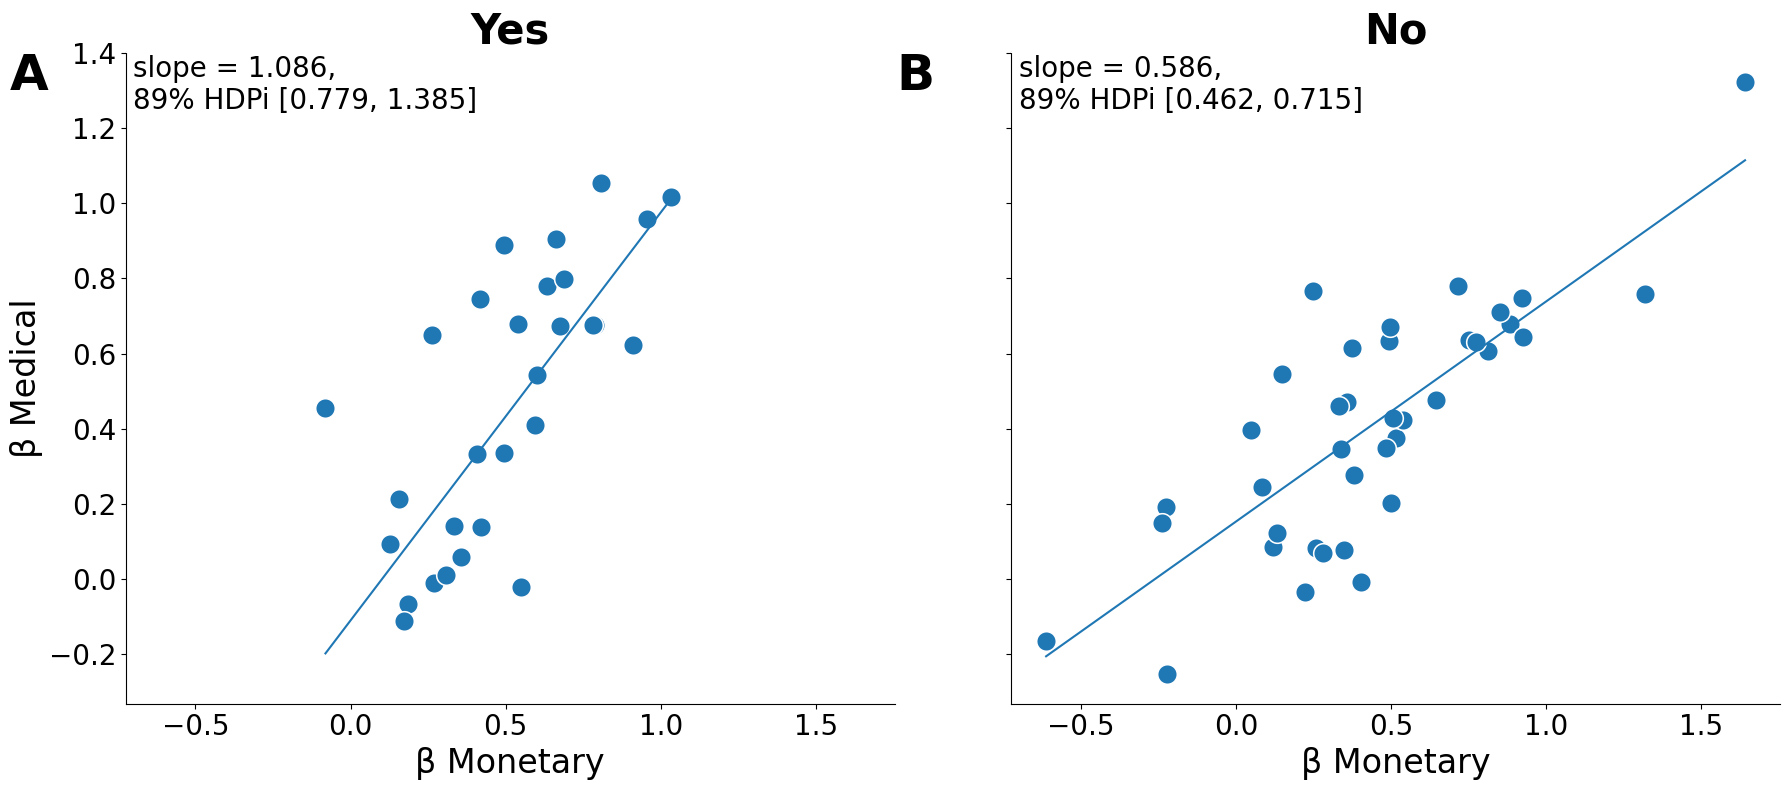

In [24]:
# This will visualize the relationship between different levels and their estimated values for Monetary and Medical contexts.
fig, axes = plt.subplots(1, 2, figsize=(18, 8), sharey=True, sharex=True) # Initialize a 1x2 subplot layout, with a shared y-axis.

sns.scatterplot(data = df, x = 'amb_est_mon', y = 'amb_est_med', s = 200, ax=axes[0])
sns.lineplot(x = df.amb_est_mon, 
             y = es['mean']['intercept']+es['mean']['slope']*df.amb_est_mon, 
             ax=axes[0])

sns.scatterplot(data = df_no, x = 'amb_est_mon', y = 'amb_est_med', s = 200, ax=axes[1])
sns.lineplot(x = df_no.amb_est_mon, 
             y = es_no['mean']['intercept']+es_no['mean']['slope']*df_no.amb_est_mon, 
             ax=axes[1])

# Set the title for each subplot.
axes[0].set_title('Yes', fontweight="bold", size=30)
axes[1].set_title('No', fontweight="bold", size=30)

texts = ['slope = {0},\n89% HDPi [{1}, {2}]'.format(es['mean']['slope'],es['hdi_5.5%']['slope'],es['hdi_94.5%']['slope']),
         'slope = {0},\n89% HDPi [{1}, {2}]'.format(es_no['mean']['slope'],es_no['hdi_5.5%']['slope'],es_no['hdi_94.5%']['slope'])]
axes[0].set_ylabel('β Medical', fontsize=24.0)

axes[0].text(-.7, 1.25, texts[0], fontsize=20)
axes[1].text(-.7, 1.25, texts[1], fontsize=20)


for i in range(2):
    axes[i].tick_params(axis='both', which='major', labelsize=20)
    
    axes[i].set_xlabel('β Monetary', fontsize=24.0)
    axes[i].set_facecolor('White')

    for spine in ['right', 'top']:
        axes[i].spines[spine].set_color('white')

    
    
subplot_labels = ['A', 'B']

for ax, label in zip(axes.flat, subplot_labels):
    
    # Position the text at the top left of each subplot
    # Adjust x and y values to change the position of the label
    ax.text(-0.1, 1, label, transform=ax.transAxes, fontsize=36, fontweight='bold', va='top', ha='right')


fig.tight_layout()

plt.savefig('figure3s.png')

In [25]:
def plot_hist(Group1, Group2, ax1_name, ax2_name, Group1_name = 'Group 1', Group2_name = 'Group 2', hpd=5.5, binw = .001):
    
    """
    Function to plot histograms comparing two groups (Control and PTSD).
    
    Parameters:
    - Group1: Data for the Group1
    - Group2: Data for the Group2
    - ax1_name: Title for the first subplot
    - ax2_name: Title for the second subplot
    - hpd: Threshold for Highest Posterior Density interval (default is 5.5)
    - binw: Bin width for the histograms (default is 0.001)
    """
    
    # Compute the difference between the mean values of the control and PTSD groups
    difference = Group1-Group2
    
    # Calculate the percentiles for the differences, using the HPD
    q1, q2 = np.percentile(difference, [hpd, 100-hpd])
    
    # Filter out the data based on the lower (q1) and higher (q2) thresholds
    bottom_data = difference[difference <= q1]
    top_data = difference[difference >= q2]


    # Create a new figure with two subplots
    f, ax = plt.subplots(1, 2, figsize=(10, 5))

    # Plot the distributions of the provided datasets (e.g., lower asymptote values) for both groups in the first subplot
    sns.histplot(Group1, binwidth=binw, ax=ax[0])
    sns.histplot(Group2, binwidth=binw, ax=ax[0])

    # Plot the distribution of the differences in the second subplot
    sns.histplot(data=difference, color='blue', ax=ax[1])

    # Update the bar colors in the difference histogram based on their position relative to the thresholds
    for bar in ax[1].patches:
        if bar.get_x() > q2:
            bar.set_color('orange')
        elif bar.get_x() < q1:
            bar.set_color('orange')
        else:
            bar.set_color('blue')

    # Add a reference line at zero in the difference histogram
    ax[1].axvline(0, color='black', linewidth=4)
    

    # Set titles for the subplots based on the provided names
    ax[0].set_title(ax1_name)
    ax[1].set_title(ax2_name)
    
    # Get the x and y limits of the first subplot
    xlim = ax[0].get_xlim()
    ylim = ax[0].get_ylim()

    # Convert the desired 0.25 inches offset into a proportional x-axis distance
    fig_width_in_inches = f.get_figwidth()  # figure width in inches
    proportional_distance = 0.25 / fig_width_in_inches * (xlim[1] - xlim[0])

    # Set the text relative to the upper right corner
    text_offset_x = xlim[1] - proportional_distance
    text_offset_y_1 = ylim[1] - (ylim[1] * 0.1)  # 10% from the top for the first text
    text_offset_y_2 = ylim[1] - (ylim[1] * 0.2)  # 20% from the top for the second text

    text = Group1_name
    ax[0].text(text_offset_x, text_offset_y_1, text, fontsize=18, color='#1f77b4', ha='right')
    text = Group2_name
    ax[0].text(text_offset_x, text_offset_y_2, text, fontsize=18, color='orange', ha='right')
    
    print("mean: ", np.mean(difference), "89% HDPi: ",q1,q2)

In [26]:
tr_Y = est.posterior.stack(draws=("chain", "draw"))
tr_N = est_no.posterior.stack(draws=("chain", "draw"))


In [27]:
be_Y = med_estimated.posterior.stack(draws=("chain", "draw"))
be_N = med_estimated_no.posterior.stack(draws=("chain", "draw"))

### Individual level

mean:  -0.5001650412502067 89% HDPi:  -0.8238483724662539 -0.15629050975117167


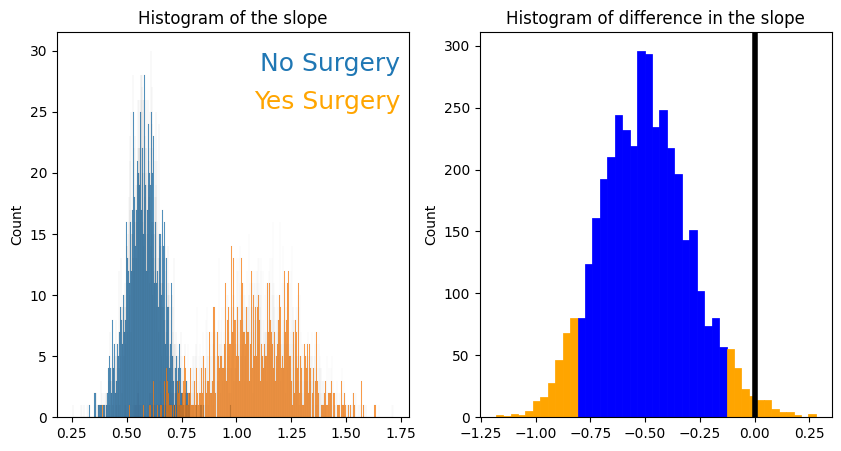

In [28]:
# Compute the mean value of the lower asymptote value
Yes = tr_Y.slope.values
No  = tr_N.slope.values


# Use the 'plot_hist' function to visualize the distributions of the lower asymptote values 
# for both Control and PTSD groups as well as their differences.
plot_hist(No, Yes, 'Histogram of the slope', 'Histogram of difference in the slope', Group1_name='No Surgery', Group2_name='Yes Surgery')


mean:  -0.06204494349993796 89% HDPi:  -0.15357873207866926 0.03017982888882605


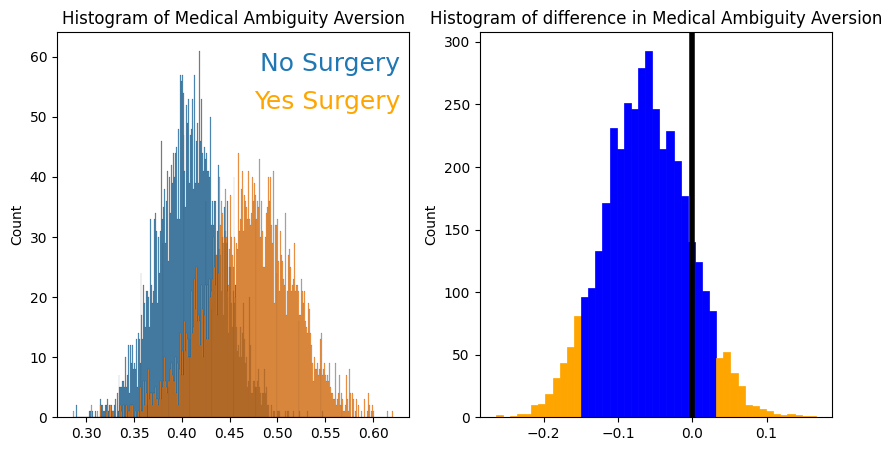

In [29]:
mb_y = np.mean(be_Y.β[:,:].values, axis = 0)
mb_n = np.mean(be_N.β[:,:].values, axis = 0)

plot_hist(mb_n, mb_y, 'Histogram of Medical Ambiguity Aversion', 'Histogram of difference in Medical Ambiguity Aversion', Group1_name='No Surgery', Group2_name='Yes Surgery')


### Population level

mean:  -0.06364804325895046 89% HDPi:  -0.2492856839019181 0.12707238848996028


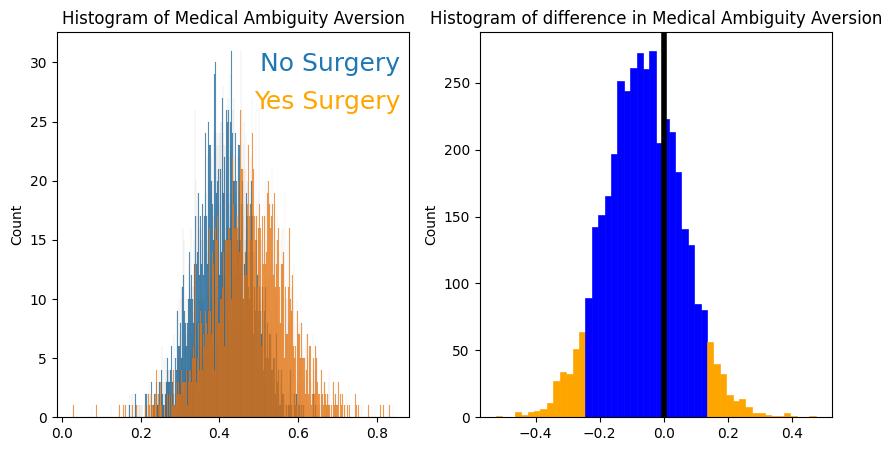

In [31]:
mb_y = be_Y.bMu.values
mb_n = be_N.bMu.values

plot_hist(mb_n, mb_y, 'Histogram of Medical Ambiguity Aversion', 'Histogram of difference in Medical Ambiguity Aversion', Group1_name='No Surgery', Group2_name='Yes Surgery')


In [32]:
%load_ext watermark
%watermark -n -u -v -iv -w -p xarray

Last updated: Mon Oct 14 2024

Python implementation: CPython
Python version       : 3.10.14
IPython version      : 8.26.0

xarray: 2024.7.0

pymc      : 4.1.7
arviz     : 0.17.1
seaborn   : 0.12.2
logging   : 0.5.1.2
matplotlib: 3.6.3
numpy     : 1.23.5
pandas    : 1.5.3

Watermark: 2.4.3

